In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc

In [2]:
sns.set_context('talk')

In [19]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [3]:
dfXtrain = pd.read_csv('preprocessed_csv/train_more.csv', index_col='id')
dfXtest = pd.read_csv('preprocessed_csv/test_more.csv', index_col='id')
dfYtrain = pd.read_csv('preprocessed_csv/y_train_more.csv', header=None, names=['INDEX', 'P_TARGET_FLAG'])

In [4]:
x_train = np.array(dfXtrain)
x_test = np.array(dfXtest)

y_train = np.array(dfYtrain['P_TARGET_FLAG'])

# Save routines

In [5]:
dfYtest = pd.DataFrame({'INDEX': dfXtest.index, 'P_TARGET_FLAG': np.zeros(x_test.shape[0])})
dfYtest.head()

,INDEX,P_TARGET_FLAG
0,3,0.0
1,9,0.0
2,10,0.0
3,18,0.0
4,21,0.0


In [6]:
def save_to_file(y, file_name):
    dfYtest['P_TARGET_FLAG'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False)

# Mix models

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier as VC
from sklearn.ensemble import RandomForestClassifier as RFC
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

XGBC = xgb.XGBClassifier

### XGB

In [8]:
class myXGBC(XGBC):
    def fit(self, *args, **kwargs):
        return super(myXGBC, self).fit(*args, eval_metric='auc', **kwargs)

In [9]:
xgb_kwargs = {'objective':'binary:logistic', 'missing': -1, 'seed': 56,
          'n_estimators': 160, 'reg_alpha': 6, 'reg_lambda': 1, 'max_depth': 3, 'colsample_bytree': 1,
          'gamma': 0.008}

xgb_best = myXGBC(**xgb_kwargs)

### 35 best of big set of features

In [11]:
class myRF(RFC):
    out_feature = np.array([  0.,   0.,   0.,   2.,   0.,   4.,   4.,   6.,   8.,   0.,   6.,
         7.,  12.,   6.,   1.,  13.,  15.,   7.,   8.,  16.,  15.,  19.,
         2.,  18.,  12.,  17.,  14.,  10.,   1.,  24.,  18.,  25.,  22.,
        15.,  34.,   9.,  30.,  13.,  32.,   5.,  34.,  17.,  19.,  34.,
        35.,   7.,  33.,  14.,  46.]) 
    
    last_out = 35

    def drop_cols(self, X):
        for features_count in range(self.out_feature.shape[0] - 1, self.last_out - 1, -1):
            out = self.out_feature[features_count]
            X = np.delete(X, out, 1)
        return X        
    
    def fit(self, X, y, *args, **kwargs):
        X = self.drop_cols(X)
        return super(myRF, self).fit(X, y, *args, **kwargs)
    
    def predict(self, X, *args, **kwargs):
        X = self.drop_cols(X)
        return super(myRF, self).predict(X, *args, **kwargs)

    def predict_proba(self, X, *args, **kwargs):
        X = self.drop_cols(X)
        return super(myRF, self).predict_proba(X, *args, **kwargs)
    
    def predict_log_proba(self, X, *args, **kwargs):
        X = self.drop_cols(X)
        return super(myRF, self).predict_log_proba(X, *args, **kwargs)


In [26]:
kwargs_more_35 = {'n_estimators': 300, 'criterion': 'entropy', 'n_jobs': -1}

more_35 = myRF(**kwargs_more_35)

### Mixing

In [24]:
def plot_quality_mix(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(np.sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)
    
    params = grid_searcher.param_grid
    
    plt.figure(figsize=(8, 6))
    x_axis = np.array(params[param_name])
    x_axis = x_axis[:, 0]
    plt.plot(x_axis, means)
    plt.fill_between(x_axis, \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel('AUC')

In [27]:
mix_clf = VC(estimators=[('more_35', more_35), ('xgb_best', xgb_best)], voting='soft')

In [30]:
%%time

params = {'weights': [[alpha, 1 - alpha] for alpha in np.arange(0, 1.01, 0.1)]}

grid_searcher = GridSearchCV(mix_clf,\
                         params, cv=5, scoring='roc_auc', n_jobs=-1)
grid_searcher.fit(x_train, y_train)

print(grid_searcher.best_score_)
print(grid_searcher.best_estimator_)

0.824984849508
VotingClassifier(estimators=[('more_35', myRF(bootstrap=True, class_weight=None, criterion='entropy', max_depth=None,
   max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
   min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=300,
   n_jobs=-1, oob_score=False, random_state=None, verbose=0,
 ...gistic',
    reg_alpha=6, reg_lambda=1, scale_pos_weight=1, seed=56, silent=True,
    subsample=1))],
         voting='soft', weights=[0.30000000000000004, 0.69999999999999996])
CPU times: user 14.2 s, sys: 240 ms, total: 14.5 s
Wall time: 3min 45s


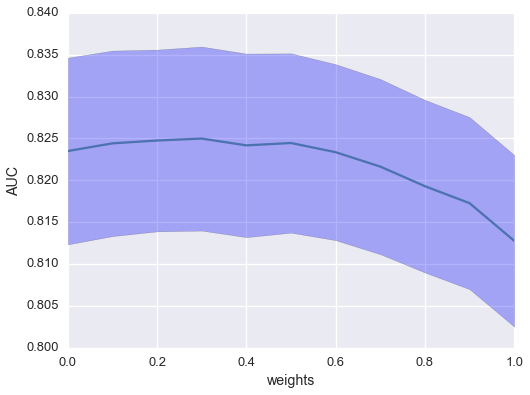

In [31]:
plot_quality_mix(grid_searcher, 'weights')

# Apply to results

In [38]:
dfYmore = pd.read_csv('results/more_35_best_100_000_cycle.csv', index_col='INDEX')
dfYxgb = pd.read_csv('results/xbgoost_grid.csv', index_col='INDEX')

In [39]:
dfYmore.head()

,P_TARGET_FLAG
INDEX,
3,0.20204
9,0.40058
10,0.10860
18,0.19002
21,0.21472


In [40]:
dfYxgb.head()

,P_TARGET_FLAG
INDEX,
3,0.164293
9,0.267080
10,0.065473
18,0.171523
21,0.152631


In [42]:
dfYbest = (0.3 * dfYmore + 0.7 *dfYxgb)
dfYbest.head()

,P_TARGET_FLAG
INDEX,
3,0.175617
9,0.307130
10,0.078411
18,0.177072
21,0.171258


In [43]:
dfYbest.to_csv('results/{}'.format('mix.csv'))